In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/Colab/data /content/data

%cd /content/drive/MyDrive/Colab
%ls

In [4]:
import sys

sys.path.append('/content/drive/MyDrive/Colab/src')
sys.path.append('./models')
sys.path.append('./tools')
from models.generator import Generator
from models.discriminator import Discriminator
from tools.ano_mnist_dataset_generator import get_ano_mnist_dataset

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
import time
import random

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
batch_size = 64
num_classes = 1
learning_rate = 0.002
num_epochs = 3000
num_color_channels = 1
num_feature_maps_g = 32
num_feature_maps_d = 32
size_z = 100
adam_beta1 = 0.2
test_size = 1

In [8]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5,), std=(.5,))
])

train_dataset = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=True,
)

test_dataset = datasets.MNIST(
    root='data',
    train=False,
    transform=transform,
    download=True,
)

#indices = (train_dataset.targets == 1) |\
#          (train_dataset.targets == 2) |\
#          (train_dataset.targets == 4) |\
#          (train_dataset.targets == 5) |\
#          (train_dataset.targets == 6) |\
#          (train_dataset.targets == 7) |\
#          (train_dataset.targets == 8) |\
#          (train_dataset.targets == 9)

indices = (train_dataset.targets == 9)
train_dataset.data, train_dataset.targets = train_dataset.data[indices], train_dataset.targets[indices]

indices = (test_dataset.targets == 9)
test_dataset.data, test_dataset.targets = test_dataset.data[indices], test_dataset.targets[indices]

ano_mnist_dataset = get_ano_mnist_dataset(transform=transform, root_dir="/content/data", labels=[9])

Generating Dataset...


Save/Load models into generator and discriminator models

In [10]:
# %cd /content/drive/My Drive/Colab/
# !ls

def save_checkpoint(epoch):
    timestamp = time.time()
    torch.save(generator.state_dict(),f'./saved_models/generator_epoch_{epoch}_{timestamp}.pkl')
    torch.save(discriminator.state_dict(),f'./saved_models/discriminator_epoch_{epoch}_{timestamp}.pkl')

def save_models():
    torch.save(generator.state_dict(),f'./saved_models/generator.pkl')
    torch.save(discriminator.state_dict(),f'./saved_models/discriminator.pkl')

def load_models():
    generator.load_state_dict(torch.load("./saved_models/generator.pkl", map_location=torch.device(device)))
    discriminator.load_state_dict(torch.load('./saved_models/discriminator.pkl', map_location=torch.device(device)))

Train the GAN

In [16]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, size_z, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))

def train_gan(dataset):
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

    print("Starting Training Loop...")
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            # get batch-size from actual image batch
            bs = real_images.shape[0]

            # -- train discriminator --

            # reset/clear discriminators gradient
            discriminator.zero_grad()

            # move images to either CPU or GPU
            real_images = real_images.to(device)

            # creates a label tensor filled with 1s
            label = torch.full((bs,), real_label, dtype=torch.float, device=device)

            # get probs for discriminators guess on the real images
            output, _ = discriminator(real_images)

            # get loss for real images. that means it calculates the difference
            # between the output of the model with the current parameter and the
            # target (goal) of what the model is supposed to do
            # output --> current outcome of the model
            # label  --> target of the model
            lossD_real = criterion(output, label)

            # calculates the gradient (using chain-rule)
            # see https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
            lossD_real.backward()

            # Gets the mean value of all results from the discriminator to get an average
            # probability of all sample evaluations (for real data ) --> D(x)
            D_x = output.mean().item()

            # create noise as an input for the G in order to create fake images
            noise = torch.randn(bs, size_z, 1, 1, device=device)

            # use generator to map input noise to an output that is supposed do become fake images during training
            fake_images = generator(noise)

            # creates a label tensor filled with 0s
            label.fill_(fake_label)

            # get discriminators guess on fake images
            output, _ = discriminator(fake_images.detach())

            # get loss for fake images
            lossD_fake = criterion(output, label)

            # adjust parameter to identify fakes
            lossD_fake.backward()

            # gets the mean value of all results from the discriminator to get an average
            # probability of all sample evaluations. this time for the fake images that were
            # generated by the generator --> D(G(z))
            D_G_z1 = output.mean().item()

            # calculate loss
            lossD = lossD_real + lossD_fake

            # adjust models (discriminator) parameter
            optimizerD.step()

            # -- train generator --

            # reset/clear generators gradient
            generator.zero_grad()

            # creates a label tensor filled with 1s
            label.fill_(real_label)

            # get discriminators guess on fake images
            output, _ = discriminator(fake_images)
            output = output.view(-1)

            # get loss for fake images
            lossG = criterion(output, label)

            # adjust parameter to generate fakes
            lossG.backward()

            # gets the mean value of all results from the discriminator to get an average
            # probability of all sample evaluations. this time for the fake images that were
            # generated by the generator --> D(G(z))
            D_G_z2 = output.mean().item()

            # adjust models (generator) parameter
            optimizerG.step()
            # Save Losses for plotting later
            G_losses.append(lossG.item())
            D_losses.append(lossD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
                with torch.no_grad():
                    fake = generator(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters += 1

        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch+1, num_epochs, lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))
        
        if epoch%200 == 0:
          print("Saving Checkpoint...")
          save_checkpoint(epoch)

    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.rcParams['animation.embed_limit'] = 100
    fig = plt.figure(figsize=(8, 8))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

Starting Training Loop...
[1/1000]	Loss_D: 0.8131	Loss_G: 1.6648	D(x): 0.6523	D(G(z)): 0.2739 / 0.2221
Saving Checkpoint...
[2/1000]	Loss_D: 0.7592	Loss_G: 2.0468	D(x): 0.7098	D(G(z)): 0.2992 / 0.1526
[3/1000]	Loss_D: 0.7123	Loss_G: 2.4336	D(x): 0.7876	D(G(z)): 0.3429 / 0.1031
[4/1000]	Loss_D: 0.8632	Loss_G: 1.3612	D(x): 0.5690	D(G(z)): 0.2018 / 0.2982
[5/1000]	Loss_D: 0.8509	Loss_G: 3.1823	D(x): 0.8079	D(G(z)): 0.4295 / 0.0531
[6/1000]	Loss_D: 0.9487	Loss_G: 2.1421	D(x): 0.7034	D(G(z)): 0.3900 / 0.1401
[7/1000]	Loss_D: 1.2935	Loss_G: 0.7671	D(x): 0.3566	D(G(z)): 0.0875 / 0.5159
[8/1000]	Loss_D: 0.8341	Loss_G: 4.5856	D(x): 0.8419	D(G(z)): 0.4385 / 0.0136
[9/1000]	Loss_D: 0.7970	Loss_G: 1.8412	D(x): 0.6308	D(G(z)): 0.2193 / 0.1920
[10/1000]	Loss_D: 0.9552	Loss_G: 3.4708	D(x): 0.8638	D(G(z)): 0.4961 / 0.0436
[11/1000]	Loss_D: 0.6203	Loss_G: 2.4568	D(x): 0.7236	D(G(z)): 0.2149 / 0.1061
[12/1000]	Loss_D: 0.5374	Loss_G: 2.7664	D(x): 0.8082	D(G(z)): 0.2367 / 0.0857
[13/1000]	Loss_D: 0.9578	L

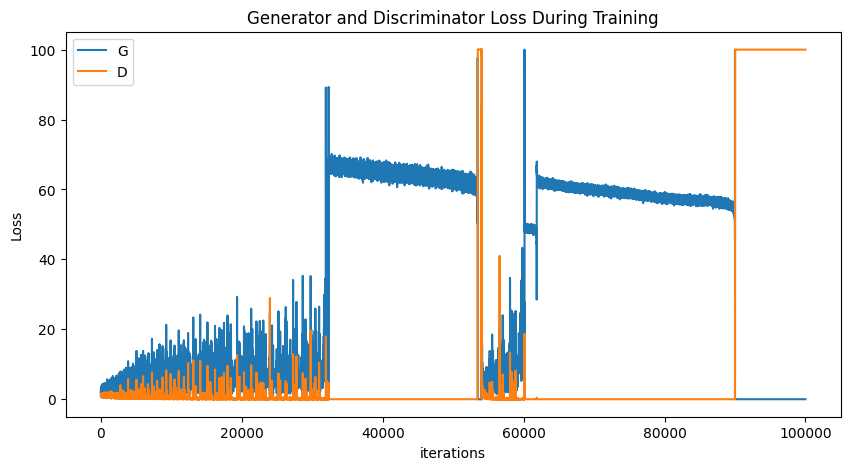

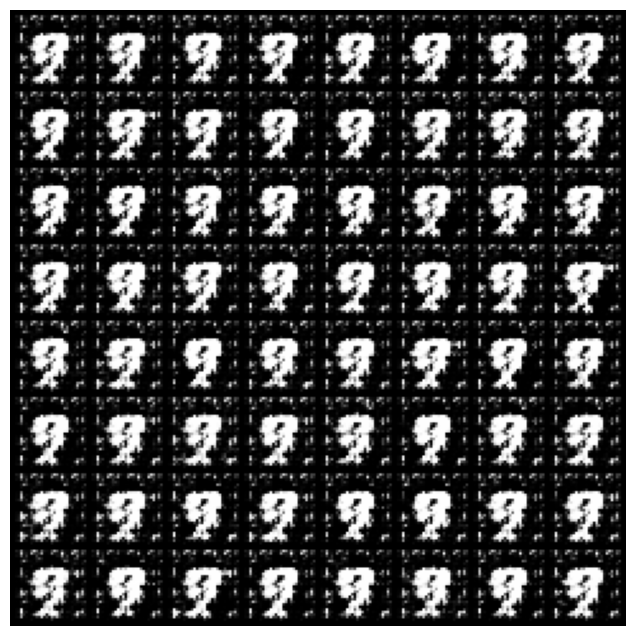

In [17]:
train_gan(ano_mnist_dataset)

Inference

In [ ]:
def generate_anomaly():
    random_idx = random.randint(0, len(test_dataset.data)-1)
    img, _ = test_dataset[random_idx]
    img = img.numpy()
    random_idx = random.randint(4, 20)
    img[0][random_idx:random_idx + 3] = np.ones(28, dtype="float32") - 2

    return np.expand_dims(img, axis=0)

def generate_normals_set(size):
    i = torch.from_numpy(np.random.randint(len(test_dataset)-1, size=size))
    train_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
    data = next(iter(train_loader))[0].numpy()[i]
    if len(data.shape) == 3: data = np.expand_dims(data, axis=0)

    return torch.from_numpy(data)

def generate_anomaly_set(size):
    anomalies = generate_anomaly()
    for i in range(size-1):
        anomalies = np.concatenate((anomalies, generate_anomaly()))

    return torch.from_numpy(anomalies)

def generate_test_set(size_normals, size_anomalies):
    normals = generate_normals_set(size_normals)
    anomalies = generate_anomaly_set(size_anomalies)

    return normals, anomalies

In [ ]:
def get_anomaly_score(z, x_query):
    lamda = 0.1
    g_z = generator(z.to(device))
    _, x_prop = discriminator(x_query)
    _, g_z_prop = discriminator(g_z)

    loss_r = torch.sum(torch.abs(x_query - g_z))
    loss_d = torch.sum(torch.abs(x_prop - g_z_prop))

    return (1 - lamda) * loss_r + lamda * loss_d

In [ ]:
def run_inference(query_image, input_type, draw_loss_curve, opt_iterations = 10000, draw_result = True):
    z = torch.randn(test_size, size_z, 1, 1, device=device, requires_grad=True).to(device)
    z_optimizer = torch.optim.Adam([z], lr=1e-4)
    losses = []
    score = 0

    for i in range(opt_iterations):
        loss = get_anomaly_score(z, query_image.unsqueeze(0).to(device))
        loss.backward()
        z_optimizer.step()
        if i % 500==0:
            losses.append(loss.data.item())
        if i == opt_iterations - 1: score = loss.data.item()

    if draw_loss_curve:
        plt.figure(figsize=(10, 5))
        plt.title("Loss trajectory during optimization")
        plt.plot(losses, label="Loss")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    if draw_result: draw_results(z, query_image, input_type, score)

    if not draw_result: print(f"Ran Inference with {opt_iterations} iterations. Query-Type was {input_type}. Anonaly-Score: {score}")
    return score

def draw_results(z, query_image, input_type, score):
    gen_fake = generator(z.to(device))
    target = query_image.squeeze().numpy()
    img = gen_fake.detach().numpy().squeeze()

    num_rows = 1
    images_in_row = 4
    f, ax = plt.subplots(num_rows, images_in_row, figsize=(10,4))

    f.add_subplot(num_rows, images_in_row, 1)
    plt.imshow(target, cmap="binary")
    plt.axis('off')
    plt.title("Query Image")

    f.add_subplot(num_rows, images_in_row, 2)
    plt.imshow(img, cmap="binary")
    plt.axis('off')
    plt.title("G(z_Gamma)")

    diff = np.abs(img - target)*255
    diff_isclose = np.isclose(img, target, rtol=1.2, atol=0.4)

    f.add_subplot(num_rows, images_in_row, 3)
    plt.imshow(Image.fromarray(diff), cmap="binary")
    plt.axis('off')
    plt.title("|G(z_Gamma) - x|")

    f.add_subplot(num_rows, images_in_row, 4)
    plt.imshow(Image.fromarray(diff_isclose), cmap="binary")
    plt.axis('off')
    plt.title("np.isclose()")

    f.suptitle(f'Sample Type: {input_type} - Score: {score}', fontsize=14)
    plt.show()

def create_roc_curve(file_path):
    data = pd.read_csv(file_path, delimiter=';').iloc[: , 1:].to_numpy()
    y_label, y_scores = np.hsplit(data, 2)
    y_label = y_label.reshape(len(y_label))
    y_scores = np.array(y_scores.reshape(len(y_scores)), dtype='float64')
    label_dict = {'normal': 0, 'anomaly': 1}
    y_label = np.array([label_dict[y_i] for y_i in y_label])

    fpr, tpr, _ = roc_curve(y_label, y_scores)
    auc_value = auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.title(f"ROC Curve - AUC: {auc_value}", fontsize=18)
    plt.xlabel("FPR", fontsize=14)
    plt.ylabel("TPR", fontsize=14)
    plt.legend()

def test_inference(size_normals, size_anomalies, draw_loss_curve = False, save_statistics = True, draw_result = True, opt_iterations = 10000):
    statistics = {
        "sample-type": [],
        "score": []
    }

    normals, anomalies = generate_test_set(size_normals, size_anomalies)
    for n in normals:
        score = run_inference(n, 'NORMAL', draw_loss_curve=draw_loss_curve, opt_iterations = opt_iterations, draw_result = draw_result)
        if save_statistics:
            statistics["sample-type"].append("normal")
            statistics["score"].append(round(score, 2))
    for a in anomalies:
        score = run_inference(a, 'ANOMALY', draw_loss_curve=draw_loss_curve, opt_iterations = opt_iterations, draw_result = draw_result)
        if save_statistics:
            statistics["sample-type"].append("anomaly")
            statistics["score"].append(round(score, 2))
    if save_statistics:
        timestr = time.strftime('%d %b %Y %H:%M:%S GMT', time.localtime())
        df = pd.DataFrame(statistics)
        df.to_csv(f'./data/statistics/stat_{timestr}.csv', sep=';')


In [ ]:
# load_models()
# test_inference(80, 20, draw_loss_curve = False, save_statistics = True, draw_result = True, opt_iterations = 10000)

In [ ]:
# file = './data/statistics/stat_02 Apr 2023 17:30:50 GMT.csv'
# create_roc_curve(file)

In [ ]:
# train_gan(ano_mnist_dataset)

In [ ]:
# save_models()